#  Прогнозирование количества заказов такси на следующий час

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

warnings.simplefilter(action='ignore', category=FutureWarning)

Загрузим и посмотрим на данные

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])     
except:
    df = pd.read_csv('c:/Users/User/Downloads/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


 Проведем ресемплирование по одному часу

In [5]:
df = df.resample('1H').sum()

Проверяем на наличие пропущенных значений

In [6]:
df.isnull().sum()

num_orders    0
dtype: int64

Проверим на дубликаты

In [7]:
df.duplicated().sum()

4165

In [8]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Построим график рассеяния для почасовых данных

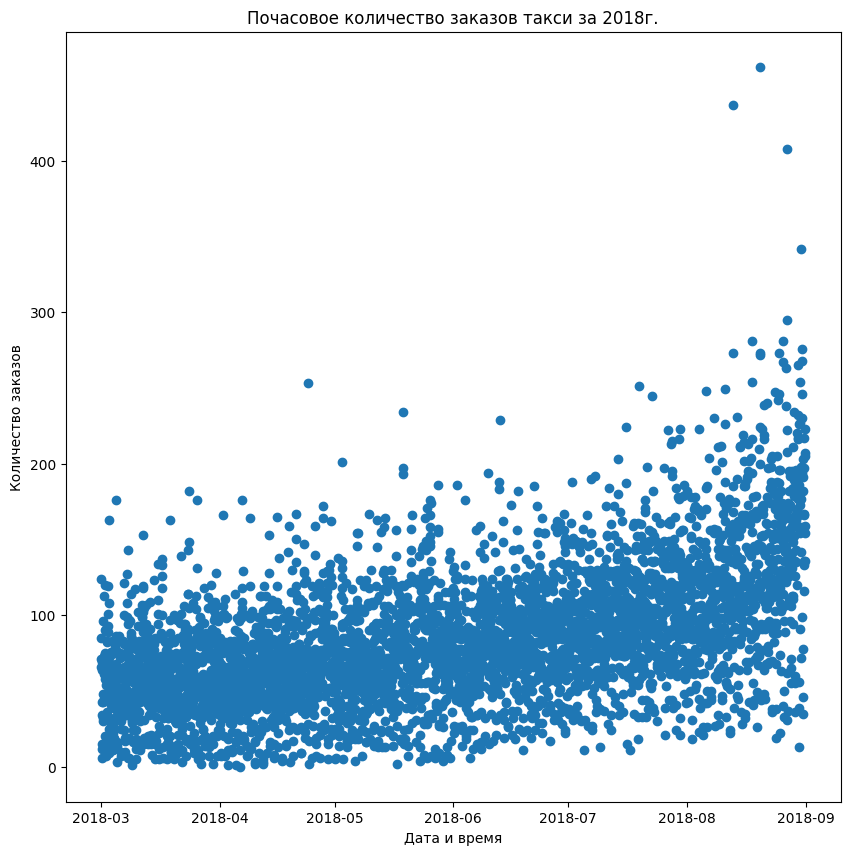

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df.index.values, df['num_orders'])
ax.set(xlabel="Дата и время",
       ylabel="Количество заказов",
       title="Почасовое количество заказов такси за 2018г.")

plt.show()

#### Вывод: 
У нас есть количество заказов за полгода 2018 года с марта по сентябрь на каждый час. Набор данных всего содержит 26 496 строк и 1 столбец с количеством заказов такси. Результаты:
- В данных нет пропущенных (NaN) значений
- В данных есть 4165 дубликатов, однако эти дубликаты могут являться следствием большого количества заказов такси примерно в одно время.
- График рассеяния показал что вне зависимости от времени большинство заказов приходится на промежуток от 0 до 100 заказов, однако ближе к сентябрю 2018 (2019-09), минимальное кол-во заказов увеличилось, а также видны необычные выбросы в данных.

## Анализ

Задача прогнозирования временного ряда состоит в построении модели, которая по историческим данным предскажет будущие значения временного ряда. Чтобы построить модель прогнозирования временных рядов, необходимо сначала преобразовать любой нестационарный ряд в стационарный. Стационарный временной ряд — это ряд, в котором среднее значение и стандартное отклонение не меняются со временем (не имеют тренда).

Построим гистрограмму для количества заказов в зависимости от времени:

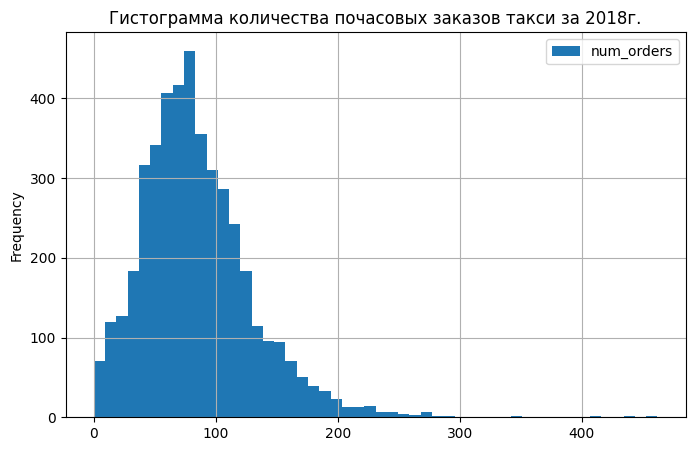

In [10]:
df.plot(kind='hist', bins=50,figsize=(8,5),title='Гистограмма количества почасовых заказов такси за 2018г.', grid=True);

Распределение приняло форму распледеления Гаусса (нормальное распределение) со сдвигом вправо.

Увеличим шаг и посмотрим на данные по месяцам:

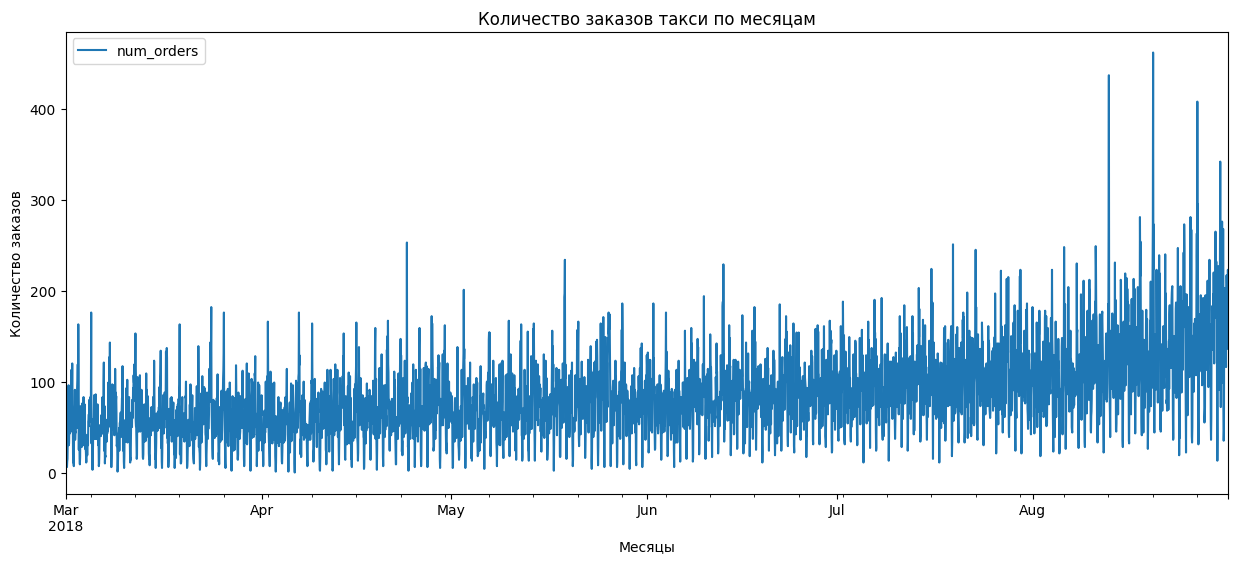

In [11]:
ax = df.plot(figsize=(15, 6))
ax.set_xlabel("Месяцы")
ax.set_ylabel("Количество заказов")
plt.title('Количество заказов такси по месяцам');

Чтобы уменьшить разность временного ряда, рассмотрим тренд, сезонность и остатки декомпозоции.

In [12]:
decomposed = seasonal_decompose(df)

Построим график тренда

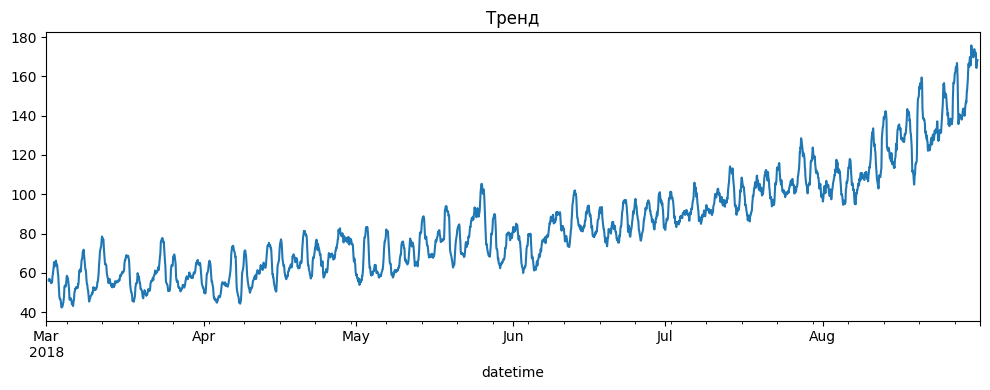

In [13]:
decomposed.trend.plot(ax=plt.gca(),figsize=(10, 4))
plt.title('Тренд')
plt.tight_layout()

Построим график сезонности

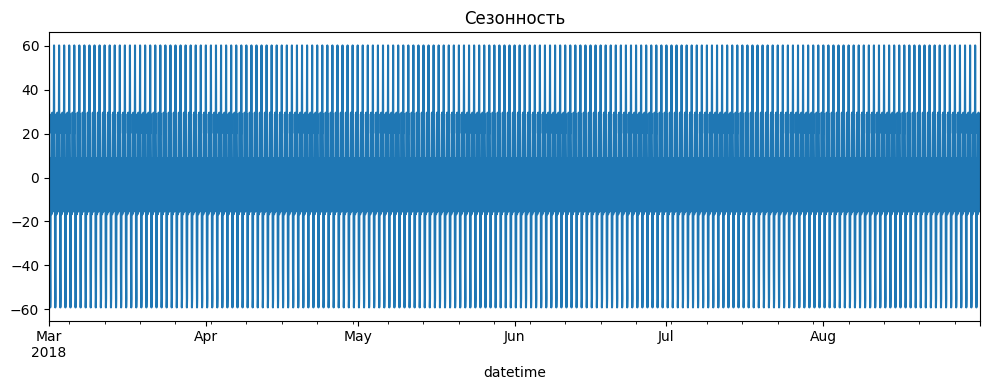

In [14]:
decomposed.seasonal.plot(ax=plt.gca(),figsize=(10, 4))
plt.title('Сезонность')
plt.tight_layout()

Построим график остатков

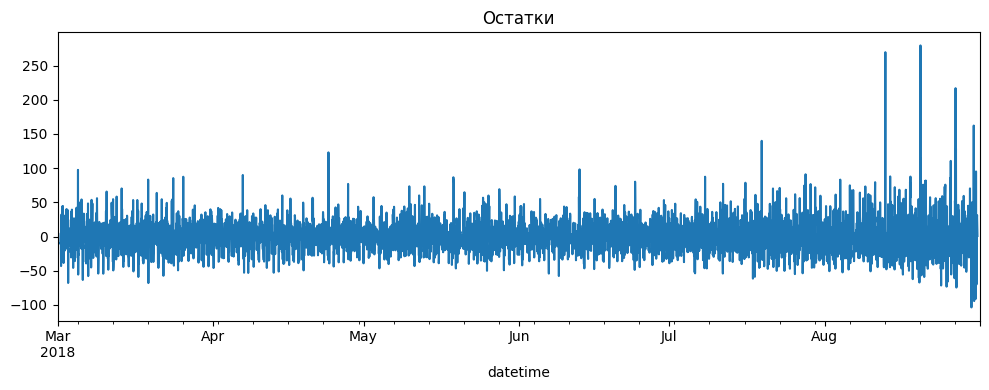

In [15]:
decomposed.resid.plot(ax=plt.gca(),figsize=(10, 4))
plt.title('Остатки')
plt.tight_layout()

Построим график с сезонной составляющей (переодически повторяющейся компонентой) за один день середины (15) августа 2018 г. (перед повышением тренда в сентябре)

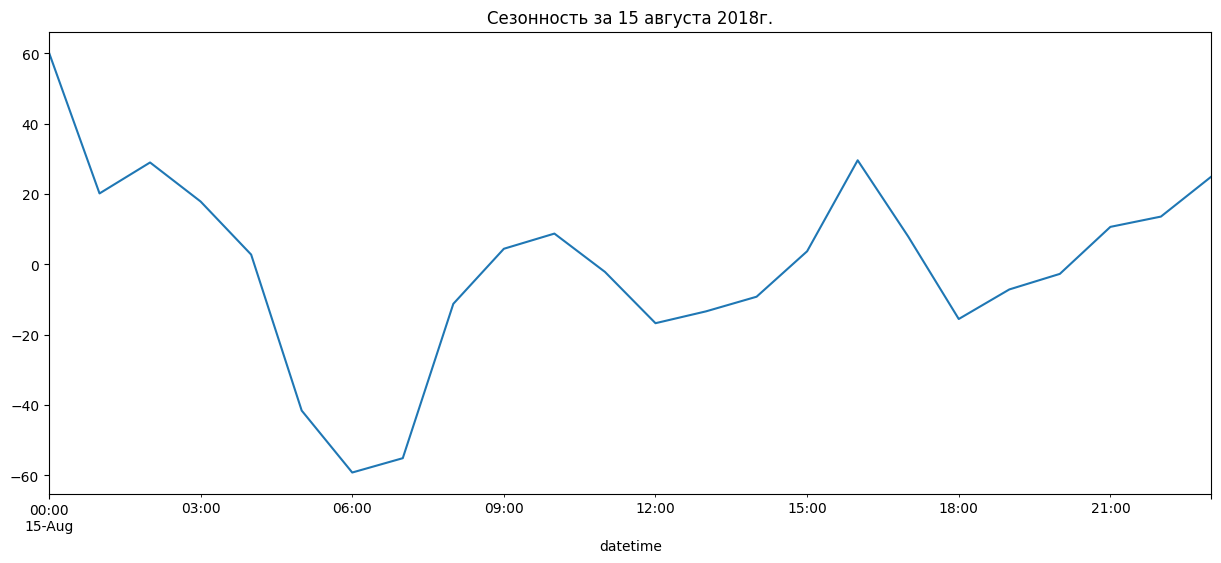

In [16]:
decomposed.seasonal['2018-08-15'].plot(figsize=(15, 6))
plt.title('Сезонность за 15 августа 2018г.');

Для сравнения построим такой же график для другого дня, например в середине (15) марта 2018г.

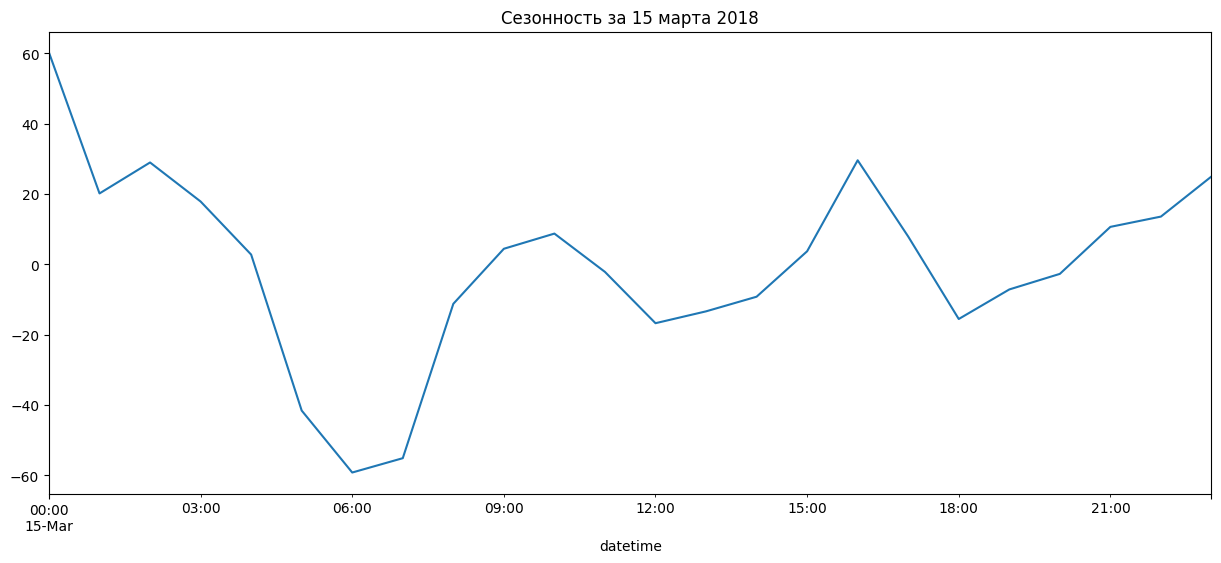

In [17]:
decomposed.seasonal['2018-03-15'].plot(figsize=(15, 6))
plt.title('Сезонность за 15 марта 2018');

Оба графика выглядят идентичными друг другу, то есть сезонность кажется независимой от времени.

Чтобы сделать данные стационарными, мы можем вычеслить разность временного ряда

Из данных за январь-июнь 2018 нужно вычесть результат вызова метода shift().

Text(0, 0.5, 'Количество заказов')

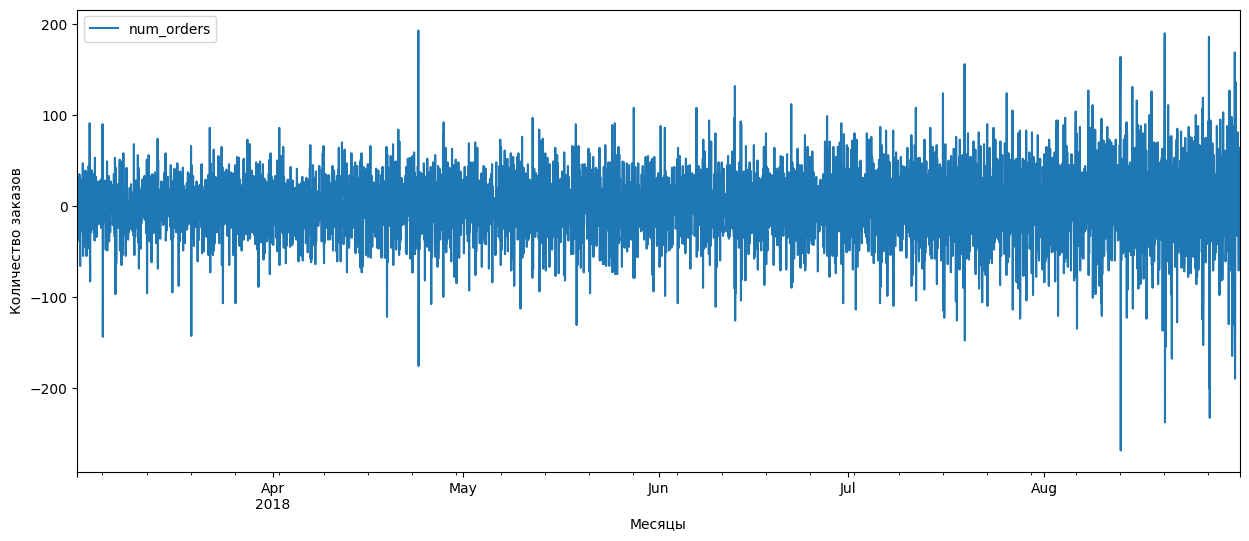

In [18]:
df_copy = df.copy()
df = df - df_copy.shift()
df.dropna(inplace=True)
ax = df.plot(figsize=(15, 6));
ax.set_xlabel("Месяцы")
ax.set_ylabel("Количество заказов")

#### Вывод: 
 - Гистограмма принимает форму нормального распределения (распределения Гаусса) со сдвигом вправо, но среднее значение изменяется на графике "Tренда" по мере приближения графика к сентябрю 2018.
 - Привели временной ряд к стационарному виду.

## Обучение

#### Подготова признаков

Создание признаков для одношагового прогноза с горизонтом в один час

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    # Формирование календарных признаков
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Формирование отстающих признаков
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # Добавление признака скользящего среднего
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

max_lag подбирается эксперементально. Вызовем функцию max_features() с max_lag = 4 и rolling_mean_size = 5.

In [20]:
make_features(df, 4, 5)

Разбиение данных на train, valid и test выборки. При работе с временными рядами перемешивать данные при разбиении на выборки нельзя

In [21]:
train_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

In [22]:
valid.index.max(), test.index.min()

(Timestamp('2018-08-13 13:00:00'), Timestamp('2018-08-13 14:00:00'))

Создание признаков и целевых признаков данных

In [23]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

#### Подборка лучшей модели

Нам необходимо эффективно подобрать наиболее эффективную модель, то есть проанализировать несколько модели и сравнить их RMSE моделей (оценка качества) и выбрать ту которая наиболее близка к нулю. Также отследим время обучения моделей. Мы обучим и проанализируем следующие модели:

- Linear Regression (Линейная регрессия)
- Random Forest (Случайный лес)
- Catboost
- LightGBM

**Модель Линейная регрессия**

In [24]:
%%time
lr = LinearRegression() # создание класса модели
lr.fit(features_train, target_train) # обучение модели
predicted_train = lr.predict(features_train) # предсказание значений для train
predicted_valid = lr.predict(features_valid) # предсказание значений для valid

# RMSE
print("RMSE обучающей выборки:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE обучающей выборки: 31.326423705858417
RMSE валидационной выборки  44.195246576785784
CPU times: total: 0 ns
Wall time: 8 ms


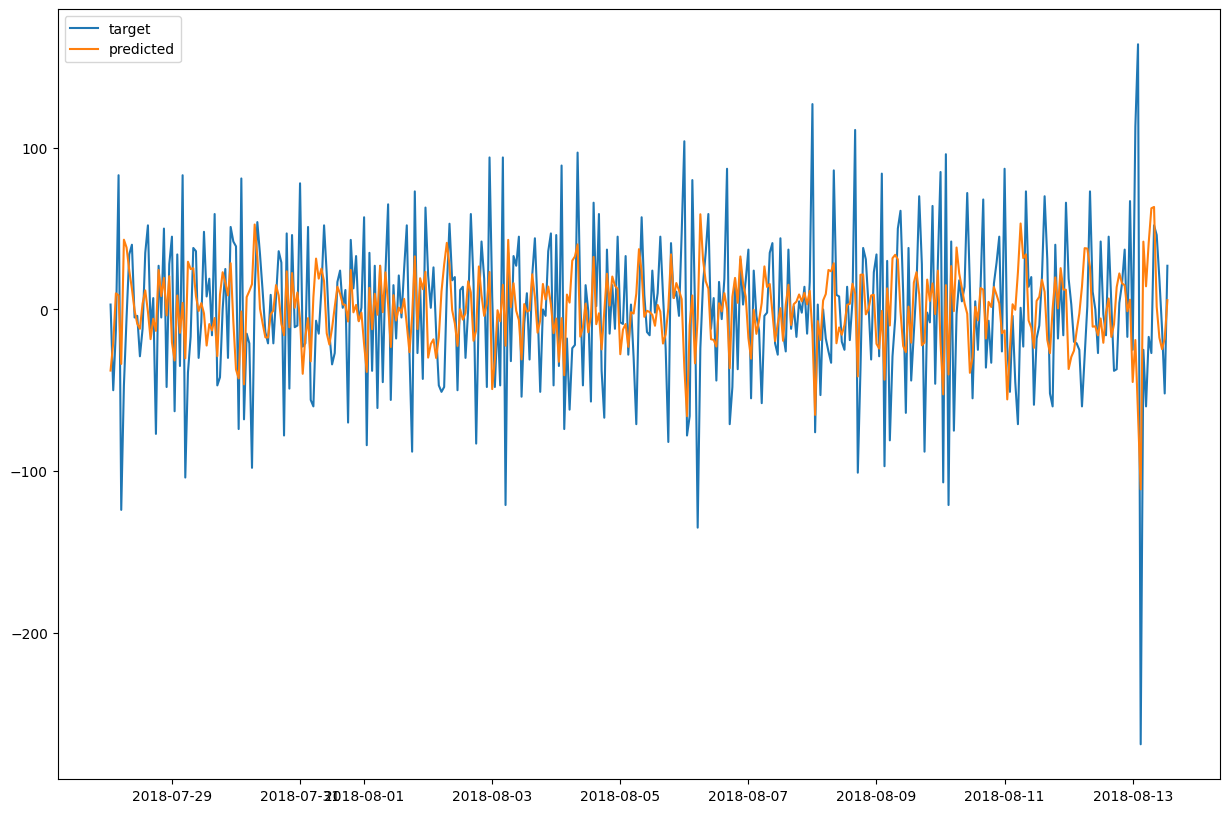

In [25]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

**Модель Случайный Лес**

In [26]:
%%time
rm = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42) # create model class
rm.fit(features_train, target_train) # обучение модели
predicted_train = rm.predict(features_train) # предсказание значений для train
predicted_valid = rm.predict(features_valid) # предсказание значений для valid

# RMSE
print("RMSE обучающей выборки:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE обучающей выборки: 23.33395162787699
RMSE валидационной выборки  37.397769745274644
CPU times: total: 1.03 s
Wall time: 1.04 s


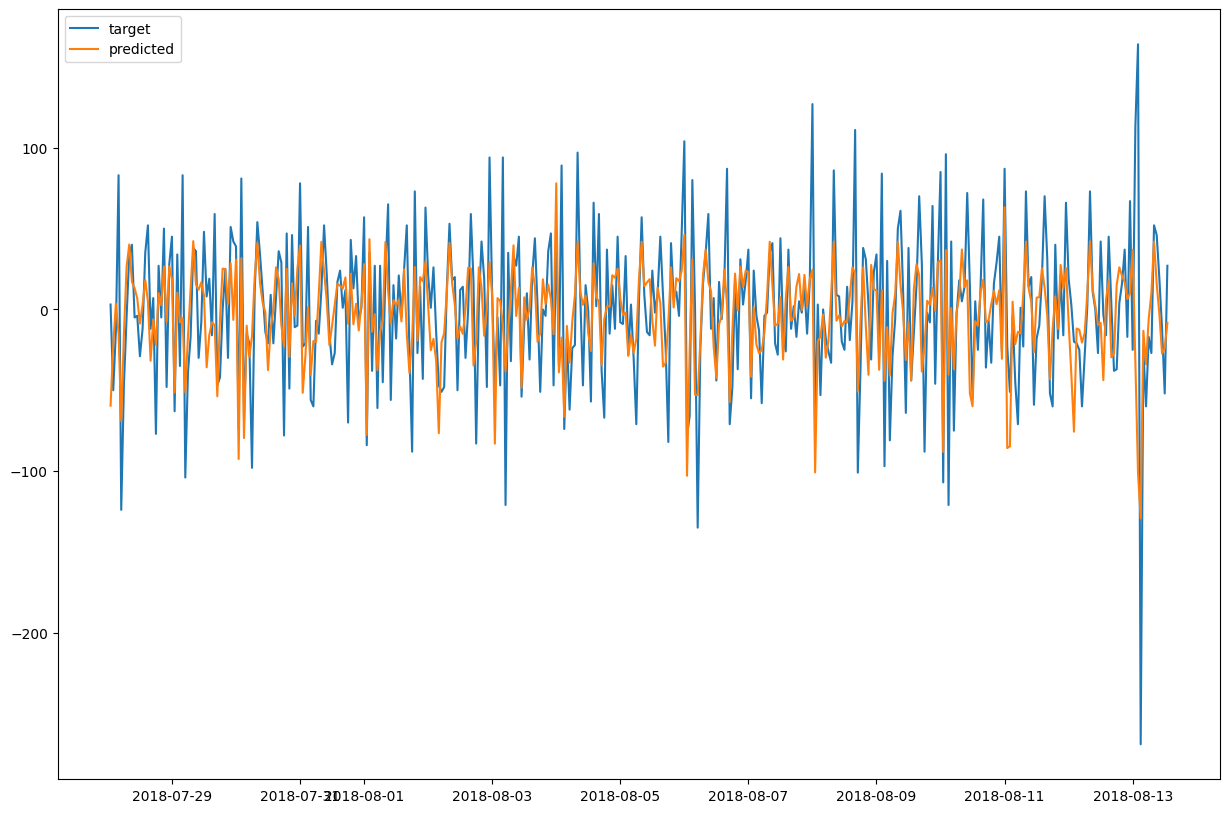

In [27]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

**Модель Catboost**

In [28]:
%%time
cb = CatBoostRegressor(n_estimators=200,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3, 
                       task_type='CPU',
                       random_state=42, 
                       verbose=False)
cb.fit(features_train, target_train) # обучение модели
predicted_train = cb.predict(features_train) # предсказание значений для train
predicted_valid = cb.predict(features_valid) # предсказание значений для valid

# RMSE
print("RMSE обучающей выборки:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE обучающей выборки: 18.814648979315137
RMSE валидационной выборки  35.930683308574714
CPU times: total: 1.55 s
Wall time: 328 ms


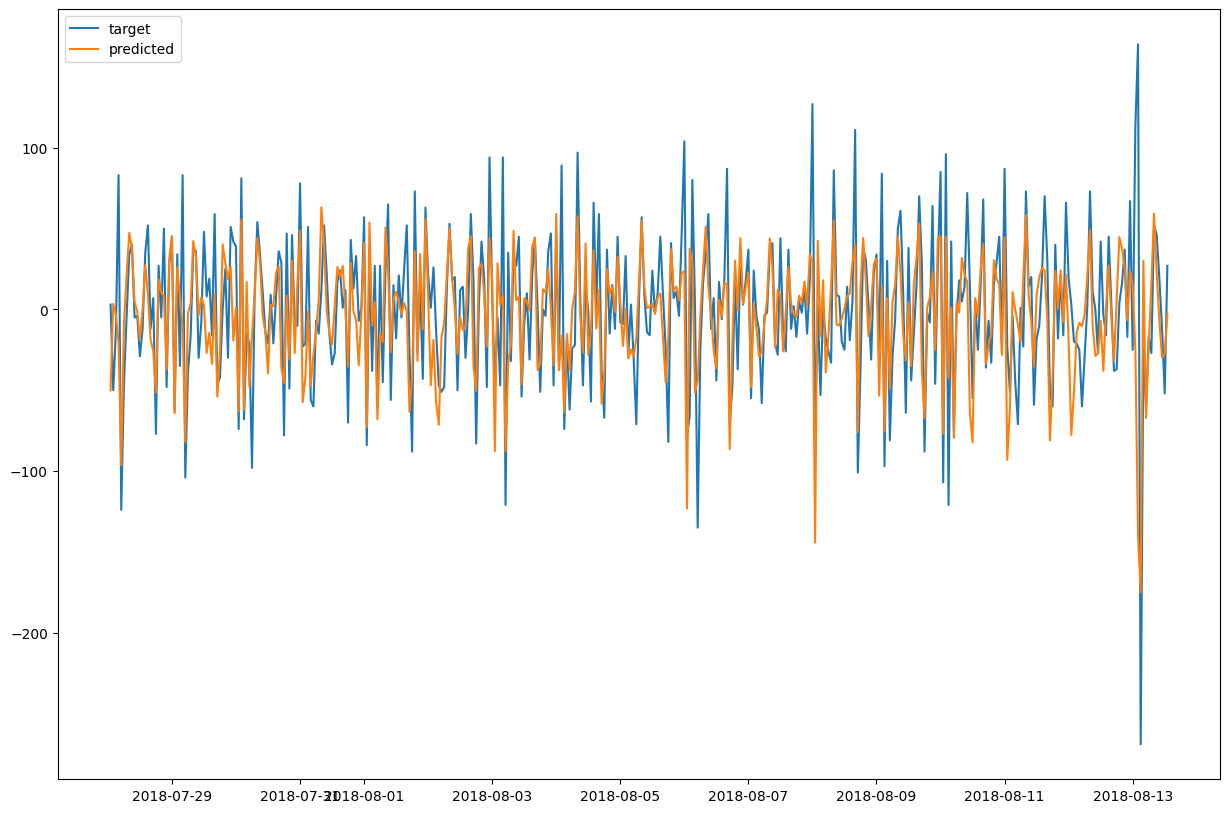

In [29]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

**Модель LightGBM**

In [30]:
%%time
estimator = lgb.LGBMRegressor(num_leaves=10)

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [5, 10]
}
tscv = TimeSeriesSplit(n_splits=3)
gbm = GridSearchCV(estimator, param_grid, cv=tscv)
gbm.fit(features_train, target_train)

print('Наилучшие гиперпараметры найденные при помощи GridSearchCV:', gbm.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 7
[LightGBM] [Info] Start training from score 0.040223
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 1787, number of used features: 7
[LightGBM] [Info] Start training from score 0.061556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 2679, number of used features: 7
[LightGBM] [Info] Start training from

In [31]:
%%time
lgb = lgb.LGBMRegressor(n_estimators=10, 
                          learning_rate=0.2, 
                          num_leaves=10, 
                          max_depth=20, 
                          random_state=42) # создание класса модели
lgb.fit(features_train, target_train) # обучение модели
predicted_train = lgb.predict(features_train) # предсказание значений для train
predicted_valid = lgb.predict(features_valid) # предсказание значений для valid

# RMSE
print("RMSE обучающей выборки:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 3571, number of used features: 7
[LightGBM] [Info] Start training from score 0.052086
RMSE обучающей выборки: 25.27216907087961
RMSE валидационной выборки  38.03969495272093
CPU times: total: 62.5 ms
Wall time: 16 ms


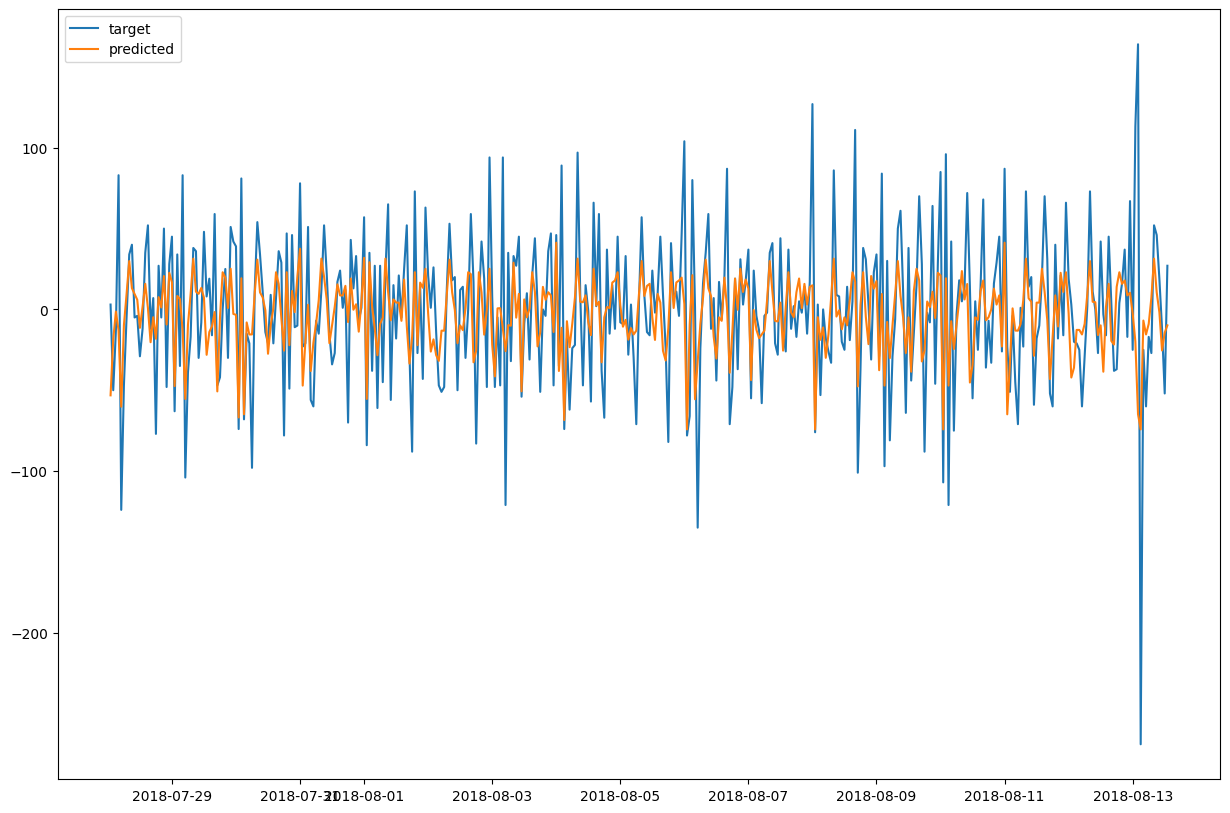

In [32]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

#### Вывод: 
- Всего было проанализировано 4 модели
- Самой быстрой моделью является линейная регрессия, но RMSE этой модель гораздо хуже остальных моделей (44.19). Catboost имеет наилучшее значение RMSE (35.93) и скорость (990 ms). У LightGBM RMSE = 38.03.
-  Для дальнейшего анализа выбираем Caboost.

## Тестирование

Тестирование модели на тестовой выборке

In [33]:
%%time
model = CatBoostRegressor(n_estimators=200,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3, 
                       task_type='CPU',
                       random_state=42, 
                       verbose=False)
model.fit(features_train, target_train) # обучение модели
predicted_test = model.predict(features_test) # предсказание значение

# RMSE тестовой выборки
print("RMSE тестовой выборки:", mean_squared_error(target_test, predicted_test) ** 0.5)

RMSE тестовой выборки: 46.83189860652769
CPU times: total: 1.31 s
Wall time: 274 ms


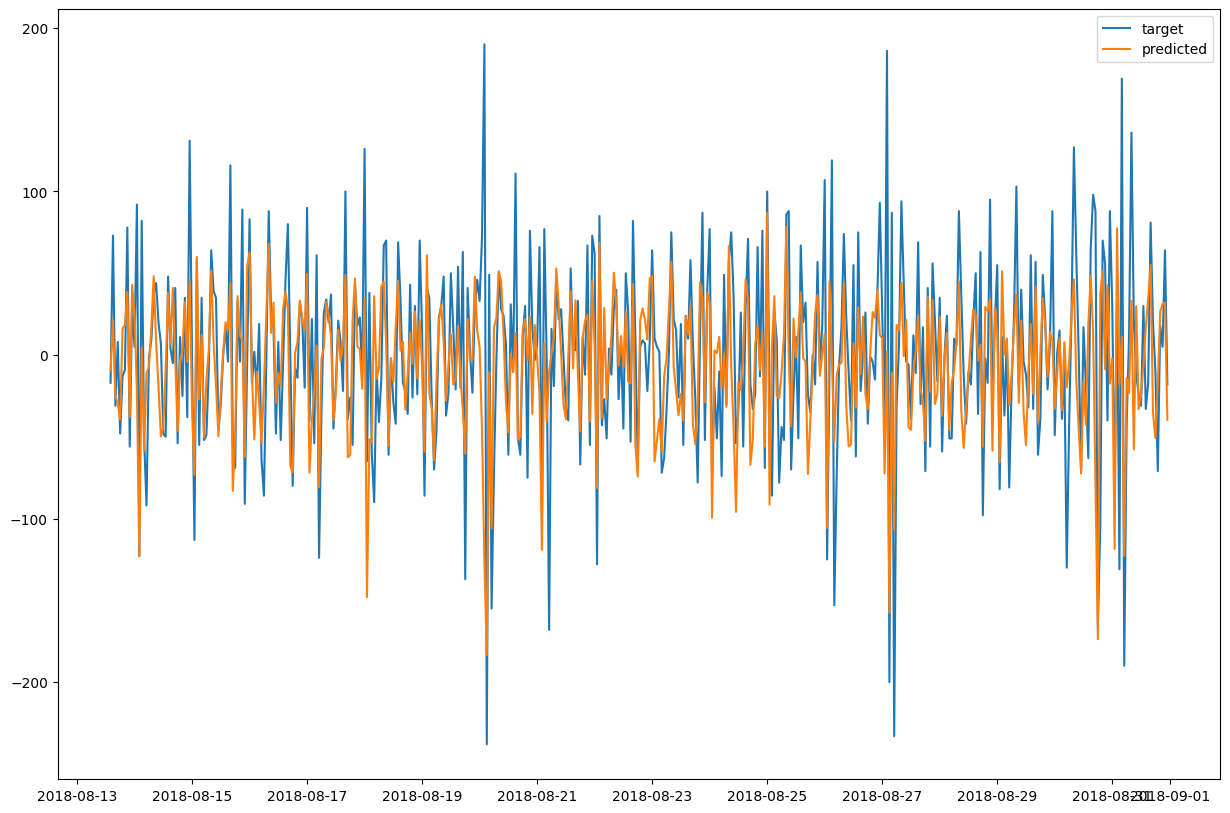

In [34]:
a = target_test.tolist()
b = predicted_test.tolist()
c = target_test.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

#### Вывод: 
На тестовой выборке и на изначальном датасете модель показала резульат RMSE хуже, чем на валидационной: (46.91 против 35.93), но это является дапустимым значением качества для заказчика (требование >=48 RMSE)

## Общий вывод
- Мы подобрали и построили модель для прогнозирования количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. 
- Сatbost - модель с наилучшим RMSE, равным 46.91 на тестовой выборке и 35.93 на валидационной. Время обучения в среднем равно 1 секунде.